# Computer Vision project

## 1. Introduction

The first part of the Computer Vision project is devoted to the development of an application for image processing and detection/extraction of lines in several picture datasets. Based on classical methods, it is known nowadays that line detection is an important building block of numerous applications like 3D scene analysis. 

This report explains how it is managed to : 
  -  read and process image from the disk memory (2.1) ;
  -  extract edge points from an image using Canny's methods (2.2) ;
  -  detecte the support lines with the Hough classical method (2.3) ;
  -  make edge points classification (2.4). 
  

## 2. Main modules development and line extraction 

### 2.1 Task 1 : Image/Video processing application 

In [207]:
%matplotlib inline

In [315]:
import numpy as np                     # Numerical algorithms on arrays
import cv2                             # OpenCV
from matplotlib import pyplot as plt   # Plot library
import matplotlib.cm as cm             # Image color map 
import tools                           # A few helpers to plot multiple images
from PIL import Image                  # For rescaling images
from ipywidgets import interact, fixed # Interact with images

Two images are chosen in order to illustrate the implemented methods. 

In [430]:
img_link = 'images/sudoku/sudoku_00007.png'

#img1
#img2

### 2.2 Task 2 : Edge points extraction 

The extraction of the edge points is performed thanks to the Canny's method. 

Before applying this, one applies two filters on the "Sudoku" picture in order to reduce the noise : a Gaussian Blur and an adaptive threshold. The parameters of those methods are ???????. After several tunings by hand, it has been decided that those values were the most suited for this image. 

For the "road" image, only the Gaussian blur appeared relevant to be applied. Once again, the parameters were tuned by hand until the output picture was assumed sufficiently filtered. 

Once those filters are applied, one rescales the size of the picture by a factor 2, in order to improve the output of the Canny's function. This can be explained by a simplification of the details of the original picture, which facilitates the detection of the edges. 

Finally, Canny is applied on the reduced images, with low and high threshold designed thanks to a sigma coefficient. It has been decided to set it to 0.3 after several tests. 

All the results of this different steps are given below. 

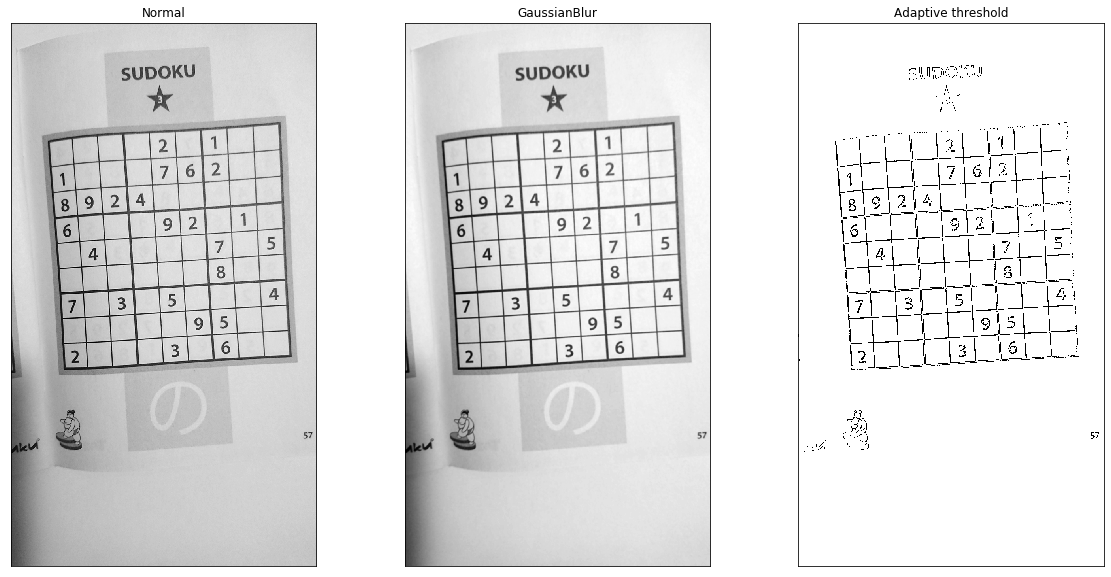

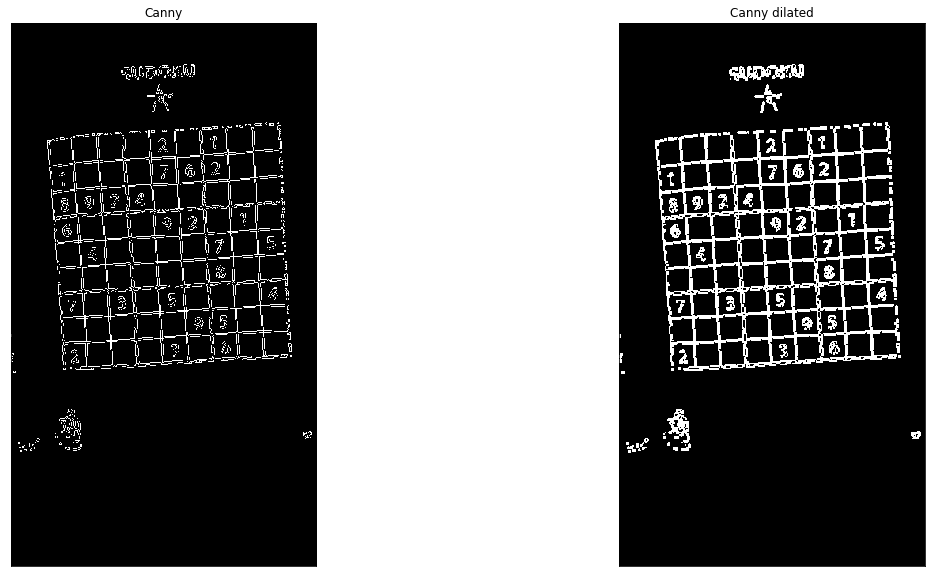

In [431]:
# prefiltrering and scaling 

img = cv2.imread(img_link, cv2.IMREAD_GRAYSCALE)
img_color = cv2.imread(img_link, cv2.IMREAD_COLOR)

iGausKernelSize = 5
imgFilt = cv2.GaussianBlur(img, (iGausKernelSize, iGausKernelSize), 0)

imgThresh = cv2.adaptiveThreshold(imgFilt, 255, cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY, 3, 5)

iReducFactor = 2
iStart = iReducFactor // 2
imgReduc = imgThresh[iStart::iReducFactor, iStart::iReducFactor]
   
# compute the median of the single channel pixel intensities
med = np.median(imgReduc)
 
# apply automatic Canny edge detection using the computed median
sigma = 0.3
loThreshold = int( max( 0, (1.0 - sigma) * med))
hiThreshold = int( min( 255, (1.0 + sigma) * med))

edges = cv2.Canny(imgReduc, loThreshold, hiThreshold, apertureSize=3, L2gradient=False)
edges_dilated = cv2.dilate(edges, np.ones((2,2), dtype=np.uint8))

# plot all the images
tools.multiPlot( 1, 3, (img, imgFilt, imgThresh,),
                       ('Normal', 'GaussianBlur', 'Adaptive threshold',),
                        cmap_tuple=(cm.gray, cm.gray, cm.gray,))

tools.multiPlot(1, 2, (edges, edges_dilated), ('Canny', 'Canny dilated'), cmap_tuple=(cm.gray, cm.gray))

### 2.3 Task 3 : Line (segment) detection

The edges images returned by Canny at the previous point contains all the pixels that are assumed to be edges. This step is about detecting and drawing lines from those points. The chosen method for this purpose if the probabilistic Hough method (????expliquer pourquoi celle là et pas l'autre???). 

The parameters of this method are rho, the angle, the threshold, the minimum line length (i.e. a detected line that has a shorter length that this value is rejected) and the maximum line gap (i.e. two lines separated by a gap less or equal to this value are assumed to belong to the same line). 

In order to tune the parameters "minLineLength" and "maxLineGap", an "interact" function has been chosen and it has been shown that values of 30 and 20 respectively are the best for the "Sudoku" picture. 

Now that the parameters of the Hough methods are fixed, one can plot the lines returned by the function on a black picture. It is necessary for the size matching to reduce the size of this picture afterwards (i.e. between the output of Canny and the output of Hough). Once this is done, those pictures can be compared thanks to the "bitwise_and" function, which will give as an output a picture containing the common pixels between both. ???expliquer aussi dilated

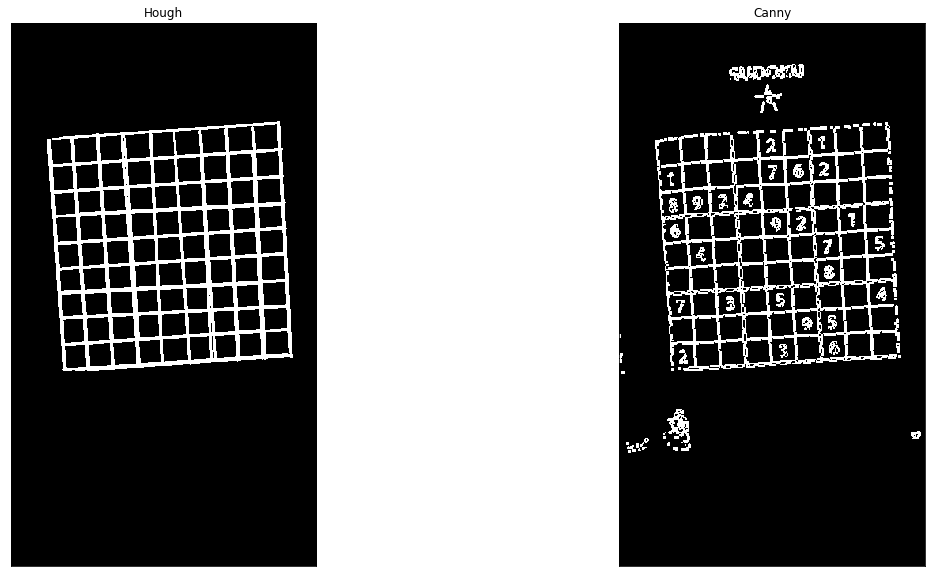

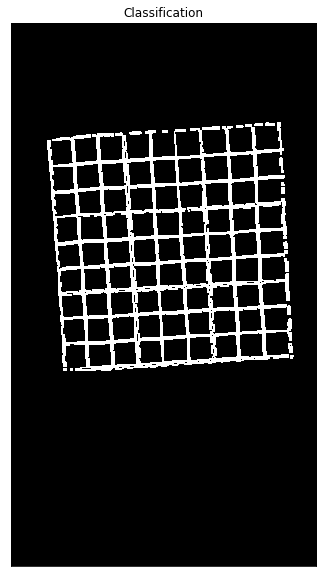

In [432]:
height, width = img.shape[:2]
mat = np.zeros((height,width))

minLineLength = 250
maxLineGap = 20

img_color = cv2.imread(img_link, cv2.IMREAD_COLOR)

lines = cv2.HoughLinesP(edges_dilated,1,np.pi/180,100,np.array([]),minLineLength,maxLineGap)
for l in lines:
    for x1,y1,x2,y2 in l:
        cv2.line(mat,(2*x1,2*y1),(2*x2,2*y2),(255, 255, 255),3)
        cv2.line(img_color,(2*x1,2*y1),(2*x2,2*y2),(255,0,0),3)

iReducFactor = 2
iStart = iReducFactor // 2
blackReduc = mat[iStart::iReducFactor, iStart::iReducFactor]


tools.multiPlot(1, 2, (mat, edges_dilated),
                        ('Hough', 'Canny'),
                        cmap_tuple=(cm.gray, cm.gray))


blackReduc = blackReduc.astype('uint8')

img_and = cv2.bitwise_and(blackReduc, edges_dilated)

dilated = cv2.dilate(img_and, np.ones((2,2), dtype=np.uint8))

tools.multiPlot(1, 1, (dilated,), ('Classification',), cmap_tuple=(cm.gray,))

### 2.4 Task 4 : Edge points classification 

Thanks to the "bitwise_and" function, it is possible to distinguished the pixels belonguing to the detected lines (in green) and the other ones (in red).

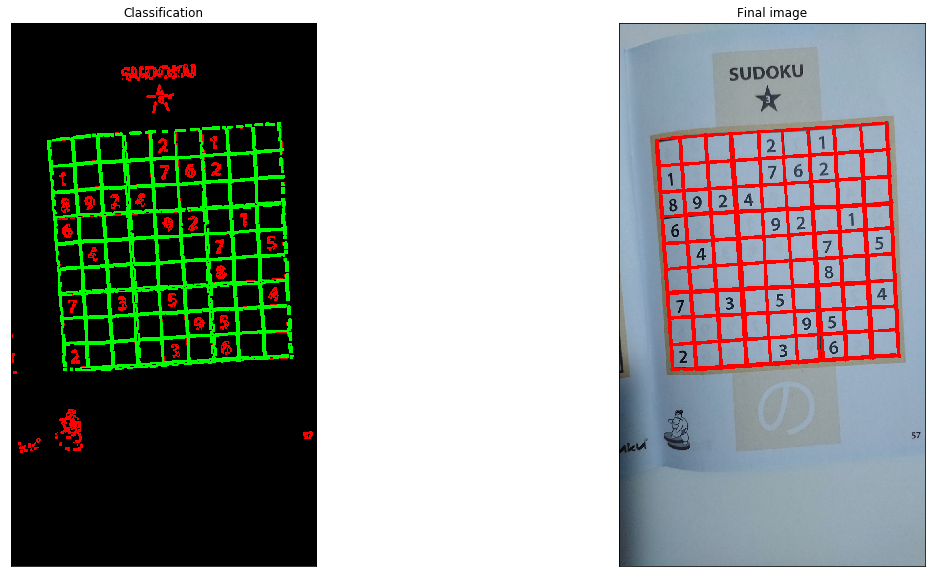

In [433]:
colored = np.zeros((dilated.shape[0], dilated.shape[1], 3), dtype='uint8')

colored[:,:,0] = edges_dilated
colored[:,:,0] -= dilated
colored[:,:,1] = dilated

tools.multiPlot(1, 2, (colored, img_color), ('Classification', 'Final image',), cmap_tuple=(cm.gray, cm.gray,))